# Image segmentation

This notebook will walk through setting up a model for the semantic segmentation of images using convolutional neural networks (CNNs). Unlike classification, where we attempt to predict a label associated with an image (e.g. cat or dog), in semantic segmentation, we are trying to label each pixel within an image. This is usually done by providing a corresponding mask for each training image that indicates which pixels belong to which class. The example used here is based on a set of aerial images taken across Dubai and used in a Kaggle competition:

https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

There are a total of 72 images and masks in this dataset. In the interest of making this tractable in a workshop, we'll just train the model using a subset (18) of these images. 

Example from https://pub.aimind.so/satellite-imagery-segmentation-using-u-net-4ec7f265ddbe

In [219]:
import os
import cv2 #pip install opencv-python
import numpy as np
import random

from matplotlib import pyplot as plt
from PIL import Image
from patchify import patchify #pip install patchify

## Setup images for model training

Let's start by defining the directory structure of our images. We have a root folder, that contains a a folder of images and a folder of matching masks. Once these are defined, we'll read in list of available images and matching masks. Note - it's really useful to have the names matching to ensure that each image is matched to its mask. 

In [220]:
root_directory = './images2/'
image_directory = root_directory + 'images/'
mask_directory = root_directory + 'masks/'
image_names = sorted(os.listdir(image_directory))
print(image_names)

['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg', 'image_part_010.jpg', 'image_part_011.jpg', 'image_part_012.jpg', 'image_part_013.jpg', 'image_part_014.jpg', 'image_part_015.jpg', 'image_part_016.jpg', 'image_part_017.jpg', 'image_part_018.jpg']


In [221]:
mask_names = [sub.replace('jpg', 'png') for sub in image_names]
print(mask_names)

['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png', 'image_part_010.png', 'image_part_011.png', 'image_part_012.png', 'image_part_013.png', 'image_part_014.png', 'image_part_015.png', 'image_part_016.png', 'image_part_017.png', 'image_part_018.png']


To see what we are working with, here is the first image and its mask:

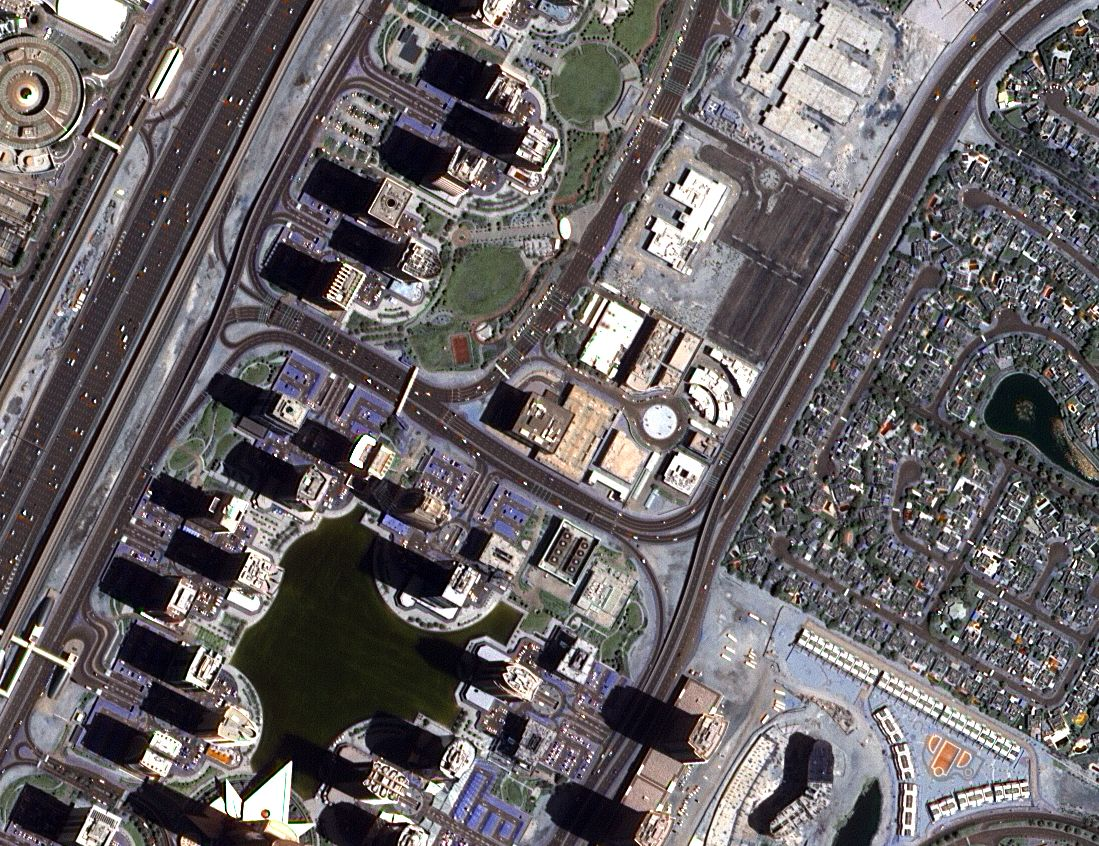

In [222]:
im = Image.open(image_directory + image_names[0])
display(im)

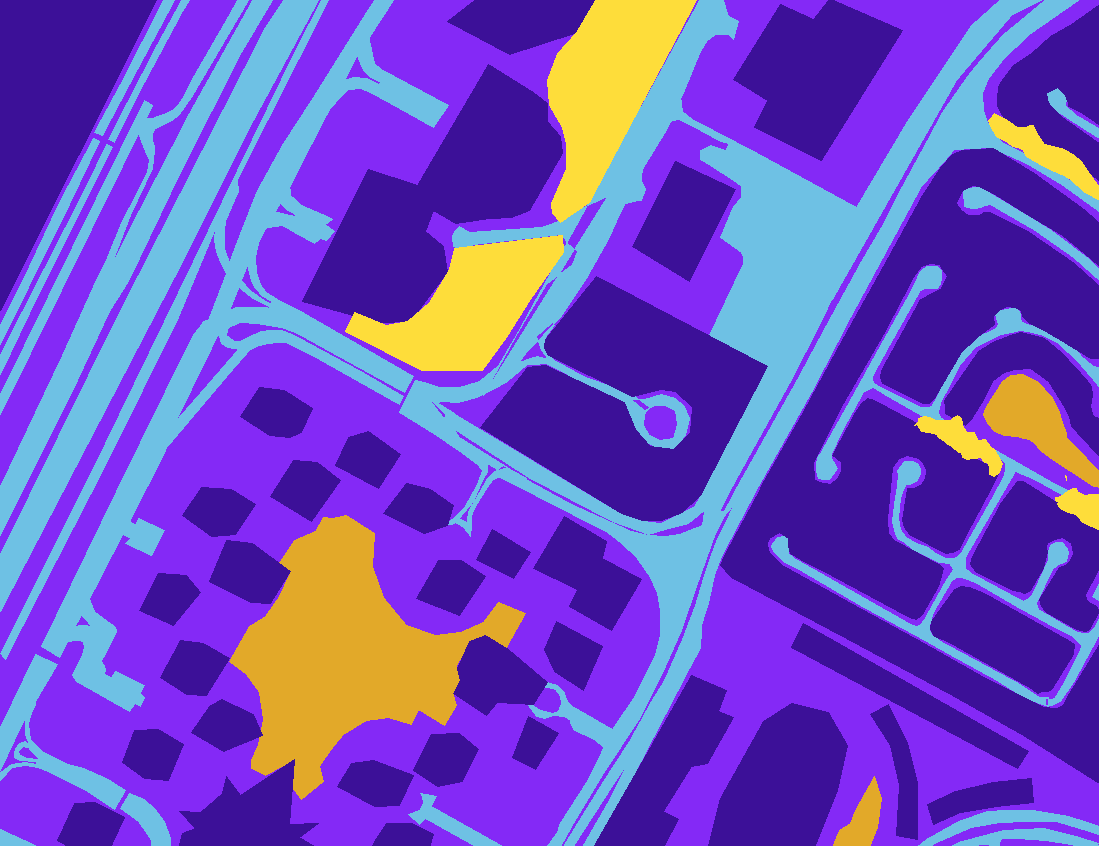

In [223]:
mk = Image.open(mask_directory + mask_names[0])
display(mk)

The images and masks we are working with a fairly large (>1000 pixels in each dimension), and we only have a small set of these (~18). This can be a problem for training a model, as CNNS require lots of examples, and large images will need a very large number of model weights. To get around this, we'll split both the images and masks into smaller sub-images (256x256 pixels) using Pythons `patchify` package. Before running this on the full dataset, we'll run through one image as an example. 

First read in the image using `OpenCV`:

In [224]:
image = cv2.imread(image_directory + image_names[0],1) 
image.shape

(846, 1099, 3)

Next, we define the size of each sub-image, as well as the step used to create the patches. We'll use a step equal to the patch size, which splits the image into non-overlapping regions. Reducing this will create a larger set of images that overlap, and may be a further way to increase the input data.

In [225]:
patch_size = 256
step_size = 256

Next, we need to make sure that the sub-images will fit within the larger image, so we crop to the nearest multiple of the patch size:

In [226]:
SIZE_X = (image.shape[1]//patch_size)*patch_size 
SIZE_Y = (image.shape[0]//patch_size)*patch_size 
image = Image.fromarray(image)
image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
image.height

768

Finally, we convert to a numpy array and create the patches. 

In [227]:
image = np.array(image) 
patches_img = patchify(image, (patch_size, patch_size, 3), step=step_size)    

And here's the first image (compare it to the image above). Note that the output of this function is a numpy array. We'll keep this format for the model, as these arrays are a very efficient way to pass data to tensorflow. Note that the dimensions of each image are 256x256x3, making this a rank 3 tensor. 

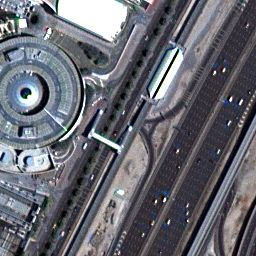

In [228]:
Image.fromarray(patches_img[0,0,0,])

Now we'll iterate across all images, convert them to smaller regions, and store as a list. We'll add an additional step where images are scaled to a [0-1] range from the original [0-255], using Scikit-Learn's `MinMaxScaler`. In general, neural networks will work more efficiently when input values are scaled in this way. 

In [229]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [230]:
image_dataset = []
for y in range(1,19):
  y2 = str(y).zfill(3)
  image = cv2.imread(f'./images2/images/image_part_{y2}.jpg',1) 
  SIZE_X = (image.shape[1]//patch_size)*patch_size 
  SIZE_Y = (image.shape[0]//patch_size)*patch_size 
  image = Image.fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
  image = np.array(image) 
  patches_img = patchify(image, (patch_size, patch_size, 3), step=step_size)  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] 
      image_dataset.append(single_patch_img) 

Now do the same for the masks (note this *has* to use the same patch and step size)

In [231]:
mask_dataset = []
for y in range(1,19):
  y2 = str(y).zfill(3)
  mask = cv2.imread(f'./images2/masks/image_part_{y2}.png',1)
  mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
  SIZE_X = (mask.shape[1]//patch_size)*patch_size 
  SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
  mask = Image.fromarray(mask)
  mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  

  mask = np.array(mask)             
        
  patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  
          
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      single_patch_mask = patches_mask[i,j,:,:]
    
      single_patch_mask = single_patch_mask[0]                         
      mask_dataset.append(single_patch_mask) 

Before continuing, we'll convert the lists of images to NumPy arrays for training:

In [232]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

Now we need to set up the masks correctly. Currently these are RGB images, as they were read from png files. This means they have 3 channels, where we only need one channel, where the values represent a single class. We have 6 classes in this dataset, given below with their color in the png file in hexadecimal:

- Building: `#3C1098`
- Land: `#8429F6`
- Road: `#6EC1E4`
- Vegetation: `#FEDD3A`
- Water: `#E2A929`
- Unlabeled: `#9B9B9B`

We start by converting these to 3 value tuples, representing the intensity of each color in the R, G, B channels:

In [234]:
def hex_to_rgb(hex_string):
    hex_string = hex_string.lstrip('#')
    rgb_tuple = np.array(tuple(int(hex_string[i:i+2], 16) for i in (0, 2, 4))) 
    return rgb_tuple

Building = hex_to_rgb('#3C1098')
Land = hex_to_rgb('#8429F6')
Road = hex_to_rgb('#6EC1E4')
Vegetation = hex_to_rgb('#FEDD3A')
Water = hex_to_rgb('#E2A929')
Unlabeled = hex_to_rgb('#9B9B9B')


Next, we define a function that will take a RGB mask image and convert it to a single integer layer with a number between 0-4 representing one of the 5 categories:

In [235]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    label_seg = label_seg[:,:,0]  
    return label_seg

As an example, this converts the first mask to a numpy integer representation and displays it:

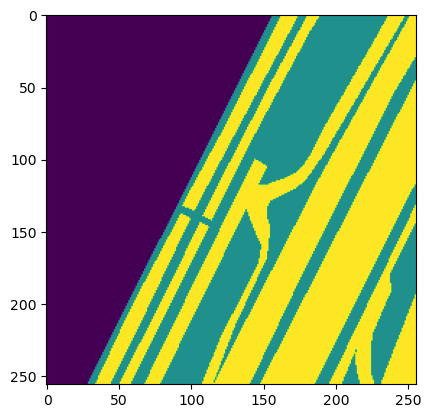

In [236]:
label = rgb_to_2D_label(mask_dataset[0])
plt.imshow(label)

Now use this function to iterate across all masks and convert to integer masks. We also convert these to numpy arrays for use in tensorflow, and use the `expand_dims` function to convert from 2D to 3D arrays. This may seem counterintuitive as the masks do not have multiple channels, but the goal is to have matching the correct *tensor* for tensorflow. Here, the targets should be a tensor of rank 3, where the third dimension is a single channel. 

In [237]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

n_classes = len(np.unique(labels))

print(f"{n_classes} unique labels in label dataset: {np.unique(labels)}")

6 unique labels in label dataset: [0 1 2 3 4 5]


Next, we'll convert these integer masks to categorical variables. This forces tensorflow to recognize these as individual categories, rather than a numeric representation

In [238]:
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

As a last step here, we'll split the data into training and testing subsets (80% training, 20% testing):

In [239]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

## Building the UNet model

We'll now set up the model. There are a few things we need to define here:
- The loss function
- Performance metrics
- Model optimizers
- The architecture

### Loss function

As segmentation is a slightly more complex problem than simple classification, we need a different form of loss function. As a reminder, the loss function is the method that describes how well the model is reproducing training data (i.e. how well it can recreate the masks). A commonly used loss function for segmentation is DICE loss. DICE loss is calculated by comparing a predicted mask (`y`) to an observed mask (`x`). The value is given as:

$(2 \times |X \cap Y|) / (|X| + |Y|)$

Where $|X|$ is the number of pixels in the observed mask, $|Y|$ is the number of pixels in the predicted mask, and $|X \cap Y|$ is the number o fpixels in the intersection or overlap of the two masks. Note that this can be weighted to preferentially predict one or more of the classes (we will use uniform weights). 

In [240]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 

### Performance metrics

We'll use two performance metrics (these will be used to assess the predictive skill of the model during validation and testing). We'll use the accuracy - a simple measure of whether a pixel in a mask is correctly predicted or not and the Jaccard coefficient (also called intersection over union). The second of these is the ratio of the overlap between a predicted and observed mask with the intersection or total areas of the two masks. At 1, this indicates a perfect prediction. We'll need to create a function to calculate this, that can then be used by the model:

In [241]:
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

### Optimizer

The optimizer is used to adjust weights during the backpropagation or training of the network. We'll use the `Adam` optimizier - this is well suited to large and complex problems, and is computationally very efficient. We'll set the learning rate to 0.001. This is an important hyperparameter in these models as it this limits the changes to model weights during training, and can help limit overfitting.

In [242]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

### Model architecture

We'll create a simplified version of Ronneburger's UNet model here. UNet is a form of autoencoder CNN that links an input image to an output image. In this example, the inputs are the satellite images, and the outputs are the masks. Autoencoders generally consist of two parts:
- A downward encoder path. This resembles a classic CNN with a mix of convolution and max-pooling steps. As a reminder, the convolution steps identify specific features of the image that can be linked to the output, and the max-pooling steps reduces the image resolution. This aggregates smaller features together, allowing the identification of larger-scale objects or parts of an image that are useful in predicting the output
- An upward decoder path. This is effectively the reverse of the encoder, and consists of a mix of up-convolution and convolution steps. The up-convolution steps disaggregates into high resolutions, ultimately recreating the original image resolution. 

One additional feature of the UNet model are 'skip-connections'. These are links between the encoder and decoder parts of the network (links between equivalent resolution layers). The skip-connections act as spatial 'anchors' helping to link the location of specific features within the entire image to their equivalent location in the mask/output. 

Tensorflow builds models as a sequence of `layers`. Each of these represents one of the actions described above (convolution, pooling, up-convolution). The first layer in the model describes the input variables, usually by defining the dimensions of a single input tensor (or image)"

```
inputs = input((dims))
```

Subsequent layers then build off this by appending new layers to the existing model. This uses the following syntax (where `layer` is the action required)

```
l1 = layer(...)(inputs)
```

As this is a fairly complex model, we'll name each step and associated layers indvidually. So `1` represents the first step (a downward step on the encoder branch). We'll use the following codes: `c`: convolution; `p`: max-pooling; `u`: up-convolution. 

In this syntax, we finish the model by calling the `Model` function to tie all of this together. Note that this requires us to specify which of the layers will receive the input tensors, and which will output values to be compared to the target masks. 


There are a few other things to note here:
- We include a set of `Dropout` layers. These randomly set a proportion of model weights to zero (effectively removing them from the training process). This acts to slow model training, which can prevent overfitting
- There are a set of `concatenate` layers. These create the skip-connections by merging steps on the downward path to the upward path
- The output of the final convolution uses a `softmax` activation. This is the standard function to predict for a set of output classes (as opposed to a bianry output or a continuous output)
- Note also that we use a Python function to create the model. This just allows us to call this if we need to recreate the mode, rather than remembering all the steps.

In [243]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])    
    return model

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

### Building the model

Now we can build the model, by first setting the input tensor dimensions, then calling the function we created above

In [244]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
print('IMG_HEIGHT',IMG_HEIGHT)
print('IMG_WIDTH',IMG_WIDTH)
print('IMG_CHANNELS',IMG_CHANNELS)

model = get_model()

IMG_HEIGHT 256
IMG_WIDTH 256
IMG_CHANNELS 3


Next, the model is compiled, which integrates together the architecture, loss, metrics and optimizer 

In [245]:
model.compile(optimizer=optim, loss=dice_loss, metrics=metrics)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_114 (Conv2D)         (None, 256, 256, 16)         448       ['input_7[0][0]']             
                                                                                                  
 dropout_54 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_114[0][0]']          
                                                                                                  
 conv2d_115 (Conv2D)         (None, 256, 256, 16)         2320      ['dropout_54[0][0]']          
                                                                                            

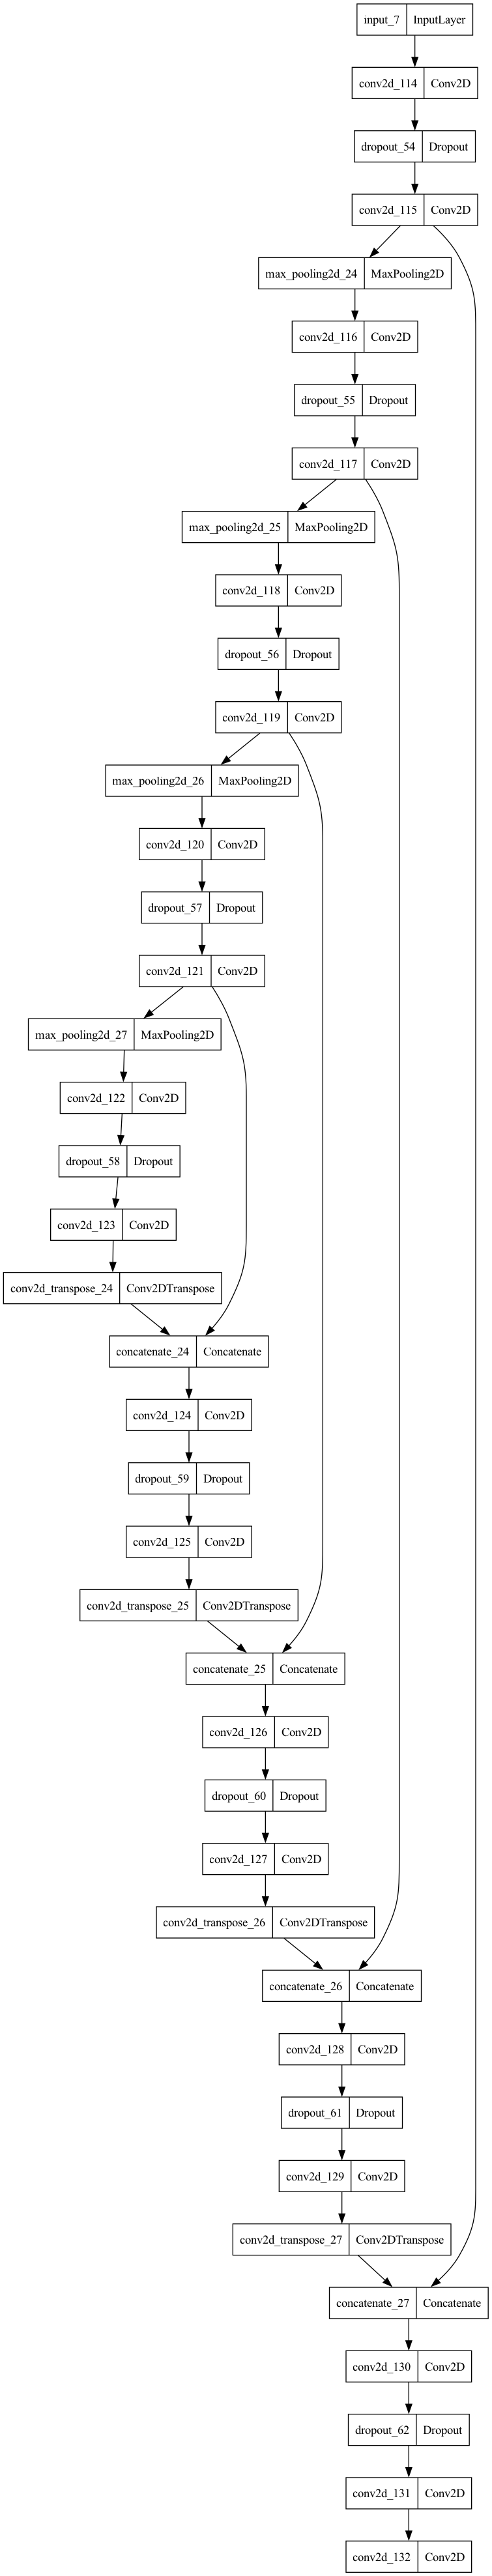

In [246]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

### Training the model

We'll now train the model for 10 epochs, where each epoch is one iteration of the model through the set of images/masks. We need to supply the training images (`X_train`) and masks (`y_train`), and use the `fit()` method to train. And we'll set the following arguments:

- `batch_size`: The number of image/mask pairs to load at a time
- `verbose`: Provides some information on the progress of training
- `epochs`: number of full training iterations
- `validation_data`: data used for validation during training
- `shuffle`: randomly shuffle images before each epoch

This takes a few minutes to train (on my laptop). It's worth remembering what is going on here: the algorithm is reading in batches of 16 images/masks, estimating loss, updating model weights through back propagation and then repeating the whole thing 10 times. As we defined a separate validation set, this routine will calculate two losses:

- The training loss. This is how accurately the model can predict the images that are being used to update the weights
- The validation loss. This is how accurately the model can predict a set of training images that are not used in updating the weights

As the model continues to train, you should see the loss (the DICE loss) decrease for both of these, but will likely stabilize at a certain point. The accuracy should (hopefully) increase over time. Note that 10 epochs is a relatively small number for this model, and in practice it would be worth increasing this number. 

In [247]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, ## Should probably be longer (50-100)
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Epoch 1/10
24/24 [==============================] - 30s 1s/step - loss: 0.9681 - accuracy: 0.3610 - jacard_coef: 0.2011 - val_loss: 0.9658 - val_accuracy: 0.3689 - val_jacard_coef: 0.2257
Epoch 2/10
24/24 [==============================] - 27s 1s/step - loss: 0.9547 - accuracy: 0.4652 - jacard_coef: 0.2718 - val_loss: 0.9453 - val_accuracy: 0.4005 - val_jacard_coef: 0.2517
Epoch 3/10
24/24 [==============================] - 27s 1s/step - loss: 0.9422 - accuracy: 0.5042 - jacard_coef: 0.3055 - val_loss: 0.9353 - val_accuracy: 0.5227 - val_jacard_coef: 0.3118
Epoch 4/10
24/24 [==============================] - 29s 1s/step - loss: 0.9328 - accuracy: 0.5442 - jacard_coef: 0.3563 - val_loss: 0.9248 - val_accuracy: 0.5524 - val_jacard_coef: 0.3648
Epoch 5/10
24/24 [==============================] - 27s 1s/step - loss: 0.9243 - accuracy: 0.5944 - jacard_coef: 0.4109 - val_loss: 0.9188 - val_accuracy: 0.5794 - val_jacard_coef: 0.3996
Epoch 6/10
24/24 [==============================] - 28s 1s/s

The output of the training is stored in `history`, and we can use this plot out the changes in the loss function and metrics:

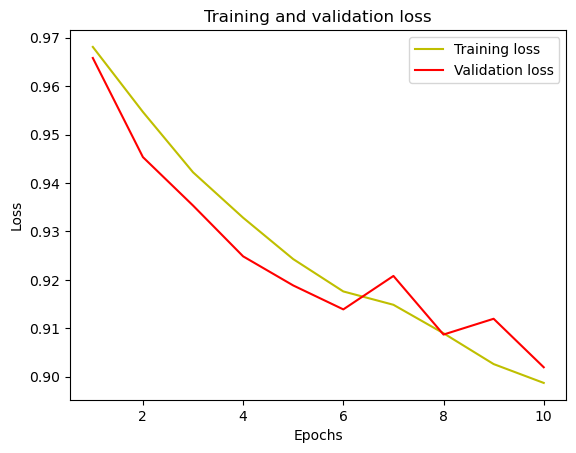

In [248]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

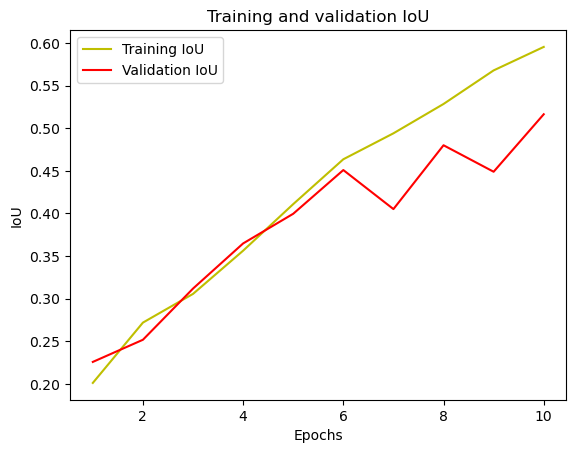

In [249]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

As a final step here, we'll predict classes for every image in the test dataset. To obtain the predictions, we first obtain the softmax prediction for each pixel. This is the probability assigned to each of our 6 land cover classes. We then select the maximum probability and use this to assign a class.

In [250]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 [==============================] - 2s 500ms/step


Now we can extract an example image, plot it, the observed mask and the predictions

1/1 [==============================] - 0s 32ms/step


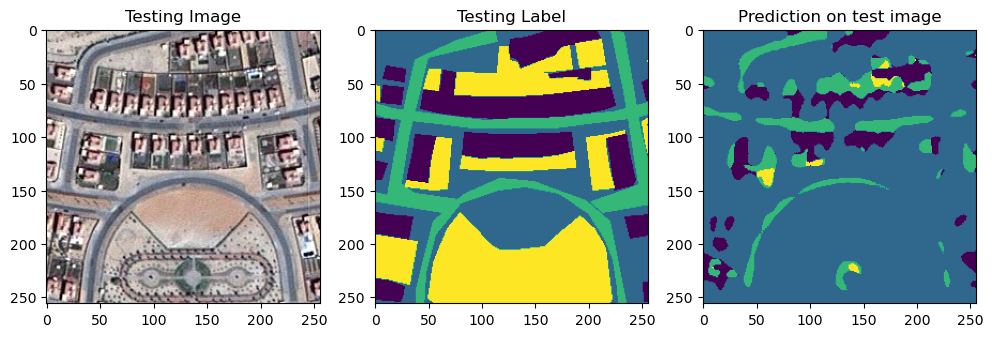

In [251]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

## Final thoughts

You'll probably see that these final results show a reasonable ability to predict the general pattern of land cover classes, but there are quite a few problems (inclusions, wrong class, etc). This is not too surprising, as this was purposefully built for a quick demonstration with a small set of images and relatively few training epochs. Future directions could include:
- Using the full dataset
- Increasing the epochs and slowing the learning rate
- Using multispectral images in additional to RGB